In [92]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import plotly.express as px
import plotly.graph_objects as go

import delong

In [47]:
# Load the data
TP_pickle = '../TP/final_tp.pkl'
TN_pickle = '../TN/final_tn.pkl'
tp = pd.read_pickle(TP_pickle)
tn = pd.read_pickle(TN_pickle)

# Exclude Y chromosome
tn = tn[tn['CHROM'] != 'Y']

# Add label
tp['LABEL'] = 1
tn['LABEL'] = 0

# Extract the columns needed
tp = tp[['LABEL', 'FinalScore', 'maxsplai']]
tn = tn[['LABEL', 'FinalScore', 'maxsplai']]

# Combine tp and tn
data = pd.concat([tp, tn], ignore_index=True)

In [65]:
def specificity_sensitivity_plotly(data):
    thresholds = np.arange(0, 11, 1)
    results = []

    for threshold in thresholds:
        tp = data[(data['FinalScore'] >= threshold) & (data['LABEL'] == 1)].shape[0]
        fn = data[(data['FinalScore'] < threshold) & (data['LABEL'] == 1)].shape[0]
        tn = data[(data['FinalScore'] < threshold) & (data['LABEL'] == 0)].shape[0]
        fp = data[(data['FinalScore'] >= threshold) & (data['LABEL'] == 0)].shape[0]
        specificity = tn / (tn + fp) if (tn + fp) else 0
        sensitivity = tp / (tp + fn) if (tp + fn) else 0

        results.append({'Threshold': threshold, 'Metric': 'Specificity', 'Value': specificity})
        results.append({'Threshold': threshold, 'Metric': 'Sensitivity', 'Value': sensitivity})

    results_df = pd.DataFrame(results)
    return results_df

def plot_sensitivity_specificity_plotly(results_df):
    # 感度と特異性のデータを分離
    specificity_df = results_df[results_df['Metric'] == 'Specificity']
    sensitivity_df = results_df[results_df['Metric'] == 'Sensitivity']

    # Plotly Graph Objectsを使用してプロット
    fig = go.Figure()

    # 特異性
    fig.add_trace(go.Scatter(
        x=specificity_df['Threshold'],
        y=specificity_df['Value'],
        mode='lines+markers',
        name='Specificity',
        text=[f'Threshold: {th}, Specificity: {val:.3f}' for th, val in zip(specificity_df['Threshold'], specificity_df['Value'])],
        hoverinfo='text'
    ))

    # 感度
    fig.add_trace(go.Scatter(
        x=sensitivity_df['Threshold'],
        y=sensitivity_df['Value'],
        mode='lines+markers',
        name='Sensitivity',
        text=[f'Threshold: {th}, Sensitivity: {val:.3f}' for th, val in zip(sensitivity_df['Threshold'], sensitivity_df['Value'])],
        hoverinfo='text'
    ))

    # Y軸のフォーマット設定
    fig.update_yaxes(tickformat=".1f")

    # グラフのレイアウト設定
    fig.update_layout(title='Sensitivity and Specificity for each threshold',
                      xaxis_title='Threshold',
                      yaxis_title='Sensitivity/Specificity',
                      plot_bgcolor='rgba(243, 243, 243, 1)',
                      paper_bgcolor='rgba(243, 243, 243, 0)',
                      font=dict(family="Arial, sans-serif", size=12, color="black"))

    # グラフサイズの調整
    fig.update_layout(width=600, height=500)
    fig.write_html("sensitivity_specificity_plot.html")

    fig.show()

# データの準備（実際のデータを使用する場合はこの部分を適宜置き換えてください）
# data = pd.DataFrame({
#     'FinalScore': np.random.rand(100) * 10,  # 0から10の範囲の乱数
#     'LABEL': np.random.randint(0, 2, 100)    # 0または1の乱数
# })

results_df = specificity_sensitivity_plotly(data)
plot_sensitivity_specificity_plotly(results_df)


In [ ]:
# Randomly sample the same number of TN as TP
tn = tn.sample(n=tp.shape[0], random_state=1)

optimal threshold:  3.0


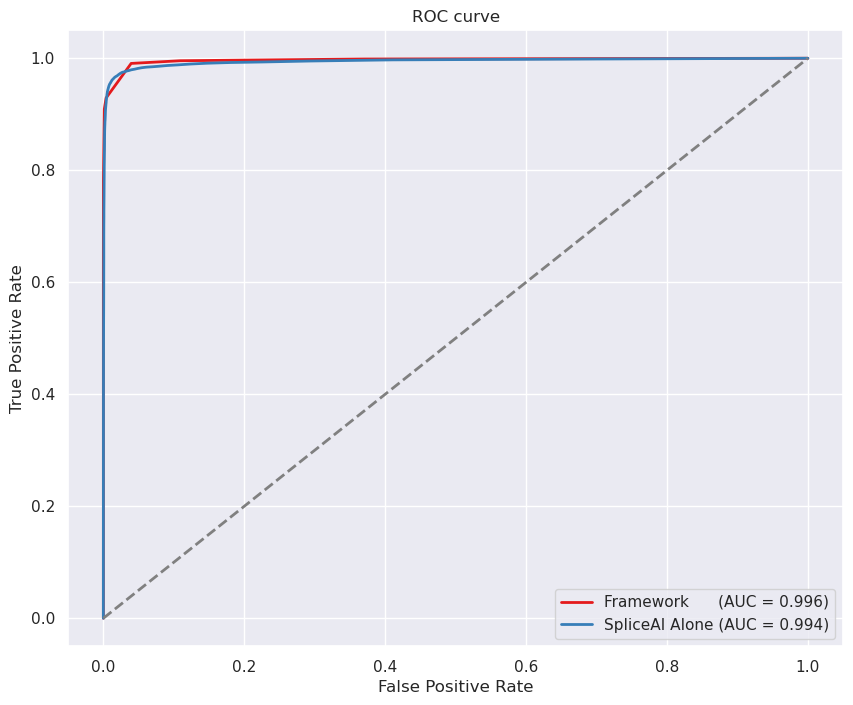

In [36]:
# ROC curve (LABEL, FinalScore)
fpr1, tpr1, thresholds1 = roc_curve(data['LABEL'], data['FinalScore'])
auc1 = roc_auc_score(data['LABEL'], data['FinalScore'])

fpr2, tpr2, thresholds2 = roc_curve(data['LABEL'], data['maxsplai'])
auc2 = roc_auc_score(data['LABEL'], data['maxsplai'])

# Calculate optimal threshold from ROC curve by Youden's J statistic
Youden_index = np.argmax(tpr1 - fpr1)
optimal_threshold = thresholds1[Youden_index]
print('optimal threshold: ', optimal_threshold)

# plot ROC curve
sns.set()

plt.figure(figsize=(10, 8))
plt.plot(fpr1, tpr1, color='#E41A1C', lw=2, label='Framework      (AUC = %0.3f)' % auc1)
plt.plot(fpr2, tpr2, color='#377EB8', lw=2, label='SpliceAI Alone (AUC = %0.3f)' % auc2)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.show()

In [91]:
import plotly.graph_objects as go
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

# データの準備（実際のデータセットを想定）
# data = pd.DataFrame({
#     'LABEL': np.random.randint(0, 2, size=100),
#     'FinalScore': np.random.rand(100),
#     'maxsplai': np.random.rand(100),
# })

# ROC curve (LABEL, FinalScore)
fpr1, tpr1, thresholds1 = roc_curve(data['LABEL'], data['FinalScore'])
auc1 = roc_auc_score(data['LABEL'], data['FinalScore'])

fpr2, tpr2, thresholds2 = roc_curve(data['LABEL'], data['maxsplai'])
auc2 = roc_auc_score(data['LABEL'], data['maxsplai'])

# Calculate optimal threshold from ROC curve by Youden's J statistic
Youden_index = np.argmax(tpr1 - fpr1)
optimal_threshold = thresholds1[Youden_index]
print('Optimal threshold (using Youden index):', optimal_threshold)

# plot ROC curve using Plotly
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=fpr1, y=tpr1, mode='lines', name=f'Framework     (AUC = {auc1:.3f})', line=dict(color='#E41A1C', width=2)))
fig.add_trace(go.Scatter(x=fpr2, y=tpr2, mode='lines', name=f'SpliceAI Alone (AUC = {auc2:.3f})', line=dict(color='#377EB8', width=2)))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Chance', line=dict(color='gray', width=2, dash='dash'), showlegend=False))

# Add titles and labels
fig.update_layout(title='ROC Curve Comparison',
                  xaxis_title='False Positive Rate',
                  yaxis_title='True Positive Rate',
                #   legend_title='Legend',
                  legend=dict(y=0.075, x=0.925, xanchor='right', yanchor='bottom', font=dict(size=14)),
                  margin=dict(l=40, r=40, t=40, b=40))

fig.update_xaxes(range=[-0.05, 1.05])
fig.update_yaxes(range=[-0.05, 1.05])
fig.update_layout(width=600, height=600)
fig.write_html("roc-auc.html")

# Show figure
fig.show()


Optimal threshold (using Youden index): 3.0


In [ ]:
## DeLong test
# Calculate AUC for each model
auc1 = roc_auc_score(data['LABEL'], data['FinalScore'])
auc2 = roc_auc_score(data['LABEL'], data['maxsplai'])

# Calculate DeLong test






In [87]:
def pred_fw(df: pd.DataFrame, cutoff: int) -> pd.DataFrame:
    df[f"FW_PRED_{cutoff}"] = df['FinalScore'].apply(lambda x: 1 if x >= cutoff else 0)
    return df

def pred_maxsplai(df: pd.DataFrame, cutoff: float) -> pd.DataFrame:
    df[f"SpliceAI_PRED_{cutoff}"] = df['maxsplai'].apply(lambda x: 1 if x >= cutoff else 0)
    return df

# confusion matrix

for i in range(0, 11):
    data = pred_fw(data, i)

for i in range(0, 10):
    data = pred_maxsplai(data, i/10)

FW: tn=0, fp=47347, fn=0, tp=10387
SA: tn=47142, fp=205, fn=755, tp=9632



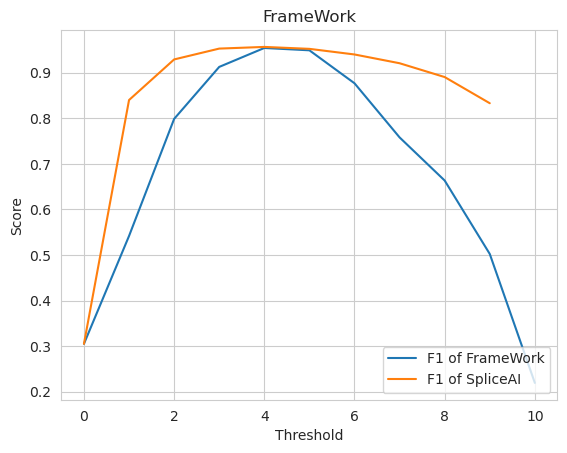

In [92]:
fw_threshold = 0
sa_threshold = 0.5

cm = confusion_matrix(data['LABEL'], data[f'FW_PRED_{fw_threshold}'])
cm2 = confusion_matrix(data['LABEL'], data[f'SpliceAI_PRED_{sa_threshold}'])

tn, fp, fn, tp = cm.flatten()
tn2, fp2, fn2, tp2 = cm2.flatten()

print(f"FW: tn={tn}, fp={fp}, fn={fn}, tp={tp}")
print(f"SA: tn={tn2}, fp={fp2}, fn={fn2}, tp={tp2}")
print("")

# fw_score: list = [accuracy_score(data['LABEL'], data[f'FW_PRED_{fw_threshold}']), precision_score(data['LABEL'], data[f'FW_PRED_{fw_threshold}']), recall_score(data['LABEL'], data[f'FW_PRED_{fw_threshold}']), f1_score(data['LABEL'], data[f'FW_PRED_{fw_threshold}'])]
# sa_score: list = [accuracy_score(data['LABEL'], data[f'SpliceAI_PRED_{sa_threshold}']), precision_score(data['LABEL'], data[f'SpliceAI_PRED_{sa_threshold}']), recall_score(data['LABEL'], data[f'SpliceAI_PRED_{sa_threshold}']), f1_score(data['LABEL'], data[f'SpliceAI_PRED_{sa_threshold}'])]

# summary = pd.DataFrame([fw_score, sa_score], columns=['Accuracy', 'Precision', 'Recall', 'F1'], index=['FrameWork', 'SpliceAI'])
# print(summary)

fw_accuracy: list = [accuracy_score(data['LABEL'], data[f'FW_PRED_{i}']) for i in range(0, 11)]
fw_precision: list = [precision_score(data['LABEL'], data[f'FW_PRED_{i}']) for i in range(0, 11)]
fw_recall: list = [recall_score(data['LABEL'], data[f'FW_PRED_{i}']) for i in range(0, 11)]
fw_f1: list = [f1_score(data['LABEL'], data[f'FW_PRED_{i}']) for i in range(0, 11)]

sa_accuracy: list = [accuracy_score(data['LABEL'], data[f'SpliceAI_PRED_{i/10}']) for i in range(0, 10)]
sa_precision: list = [precision_score(data['LABEL'], data[f'SpliceAI_PRED_{i/10}']) for i in range(0, 10)]
sa_recall: list = [recall_score(data['LABEL'], data[f'SpliceAI_PRED_{i/10}']) for i in range(0, 10)]
sa_f1: list = [f1_score(data['LABEL'], data[f'SpliceAI_PRED_{i/10}']) for i in range(0, 10)]


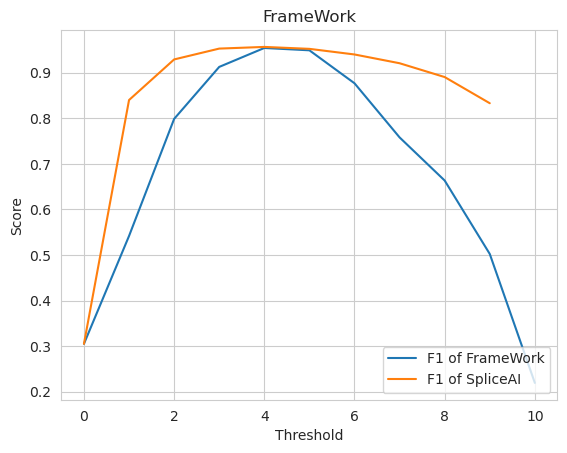

In [104]:

plt.figure()
# plt.plot(fw_accuracy, label='Accuracy of FrameWork')
# plt.plot(fw_precision, label='Precision of FrameWork')
# plt.plot(fw_recall, label='Recall of FrameWork')
plt.plot(fw_f1, label='F1 of FrameWork')

# plt.plot(sa_accuracy, label='Accuracy of SpliceAI')
# plt.plot(sa_precision, label='Precision of SpliceAI')
# plt.plot(sa_recall, label='Recall of SpliceAI')
plt.plot(sa_f1, label='F1 of SpliceAI')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('FrameWork')
plt.legend(loc="lower right")
plt.show()



In [9]:
tp['FinalScore'].value_counts()

FinalScore
9     2205
6     1774
8     1673
5     1329
10    1278
7     1185
3      641
4      206
2       50
1       32
0       14
Name: count, dtype: int64

In [25]:
print(auc)

0.9964874225845729


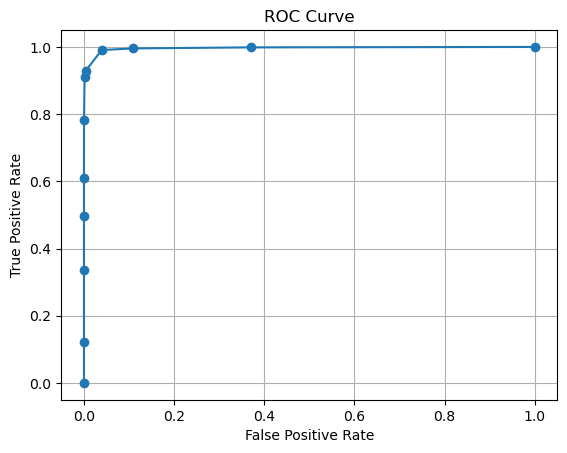

In [20]:
plt.plot(fpr, tpr, marker='o')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid()

0.9943155009177037


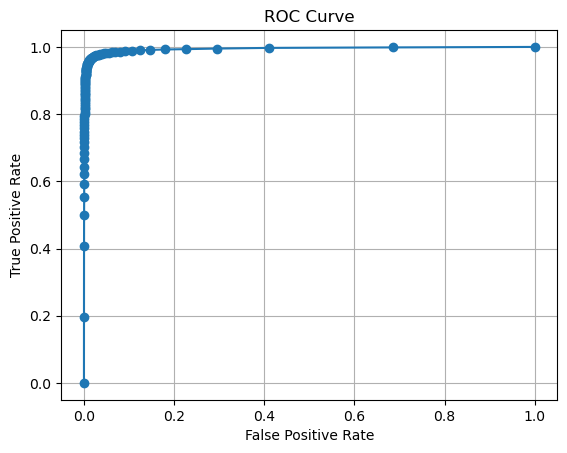

In [26]:
# ROC (LABEL, maxsplai)
fpr, tpr, thresholds = roc_curve(data['LABEL'], data['maxsplai'])
auc = roc_auc_score(data['LABEL'], data['maxsplai'])
print(auc)
plt.plot(fpr, tpr, marker='o')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid()

array([ inf, 1.  , 0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91,
       0.9 , 0.89, 0.88, 0.87, 0.86, 0.85, 0.84, 0.83, 0.82, 0.81, 0.8 ,
       0.79, 0.78, 0.77, 0.76, 0.75, 0.74, 0.73, 0.72, 0.71, 0.7 , 0.69,
       0.68, 0.67, 0.66, 0.65, 0.64, 0.63, 0.62, 0.61, 0.6 , 0.59, 0.58,
       0.57, 0.56, 0.55, 0.54, 0.53, 0.52, 0.51, 0.5 , 0.49, 0.48, 0.47,
       0.46, 0.45, 0.44, 0.43, 0.42, 0.41, 0.4 , 0.39, 0.38, 0.37, 0.36,
       0.35, 0.34, 0.33, 0.32, 0.31, 0.3 , 0.29, 0.28, 0.27, 0.26, 0.25,
       0.24, 0.23, 0.22, 0.21, 0.2 , 0.19, 0.18, 0.17, 0.16, 0.15, 0.14,
       0.13, 0.12, 0.11, 0.1 , 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03,
       0.02, 0.01, 0.  ])